## Visualização dos dados - interativos

Nesse notebook são feitos os protótipos da visualizações interativas dos dados

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from utils.load_csv import load_csv
from utils.load_shp import load_shp
from utils.save_graph import save_graph

In [2]:
df_ppa_reg = load_csv("ppa_reg.csv")

gdf_subprefs = load_shp("subprefs.shp")

#### Visualização 1 – Despesa Regionalizável por Subprefeitura e Ano do PPA

Tratamento +

In [3]:
df_grouped_mapas = df_ppa_reg.groupby("descricao prefeitura regional")[["valor 2022", "valor 2023", "valor 2024", "valor 2025"]].sum().reset_index()

In [4]:
gdf_mapa = gdf_subprefs.merge(df_grouped_mapas, 
                              how = "left", 
                              left_on = "nm_subpref", 
                              right_on = "descricao prefeitura regional")

Plots

2022

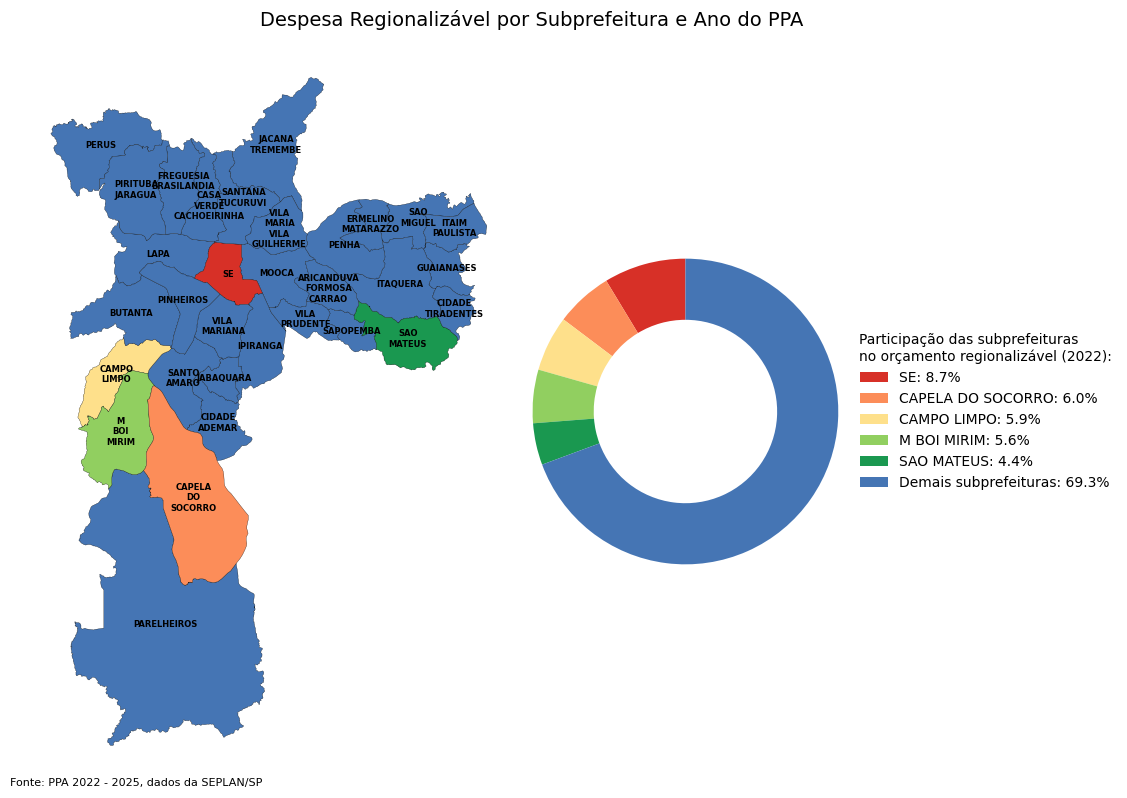

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

# --- Calcula centroides ---
gdf_mapa["centroid"] = gdf_mapa.geometry.centroid

# Dicionário de deslocamentos em metros (ajustes finos)
deslocamentos = {
    "FREGUESIA-BRASILANDIA": (500, 500),
    "CASA VERDE-CACHOEIRINHA": (500, -500),
    "SANTANA-TUCURUVI": (500, 500),
}

# Aplica deslocamentos criando colunas finais
gdf_mapa["desloc_x"] = gdf_mapa.apply(
    lambda row: row["centroid"].x + deslocamentos.get(row["nm_subpref"], (0,0))[0],
    axis=1
)

gdf_mapa["desloc_y"] = gdf_mapa.apply(
    lambda row: row["centroid"].y + deslocamentos.get(row["nm_subpref"], (0,0))[1],
    axis=1
)

# --- Calcula percentual do orçamento ---
gdf_mapa["percentual"] = gdf_mapa["valor 2022"] / gdf_mapa["valor 2022"].sum() * 100
gdf_mapa_sorted = gdf_mapa.sort_values("valor 2022", ascending=False)

# --- Top 5 + Outros ---
top5 = gdf_mapa_sorted.iloc[:5]
outros = pd.DataFrame({
    "nm_subpref": ["Demais subprefeituras"],
    "valor 2022": [gdf_mapa_sorted.iloc[5:]["valor 2022"].sum()],
    "percentual": [gdf_mapa_sorted.iloc[5:]["valor 2022"].sum() / gdf_mapa["valor 2022"].sum() * 100]
})

# Concatena Top5 + Outros
plot_df = pd.concat([top5[["nm_subpref", "valor 2022", "percentual"]], outros], ignore_index=True)

# --- Define cores específicas para cada posição ---
colors = ["#d73027", "#fc8d59", "#fee08b", "#91cf60", "#1a9850", "#4575b4"]  # top 5 + outros

# Cria dicionário de cores baseado no gráfico
color_map = dict(zip(plot_df["nm_subpref"], colors))

# Cria coluna de grupo no gdf (top5 ou Outros)
gdf_mapa["grupo_cor"] = gdf_mapa["nm_subpref"].where(gdf_mapa["nm_subpref"].isin(top5["nm_subpref"]), "Demais subprefeituras")

# Mapeia a cor para cada subprefeitura
gdf_mapa["cor"] = gdf_mapa["grupo_cor"].map(color_map)

# --- Cria figura com dois subplots (mapa + rosca) ---
fig, (ax_map, ax_pie) = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [2, 1]})

# --- Mapa ---
gdf_mapa.plot(color=gdf_mapa["cor"],
              linewidth=0.2,
              edgecolor="black",
              ax=ax_map)

# Escreve nomes das subprefeituras
for _, row in gdf_mapa.iterrows():
    nome = "\n".join(row["nm_subpref"].replace("-", " ").split())
    ax_map.text(row["desloc_x"], row["desloc_y"],
                nome,
                fontsize=6,
                ha="center",
                va="center",
                fontweight="bold",
                color="black")

ax_map.axis("off")

# --- Título principal ---
fig.suptitle("Despesa Regionalizável por Subprefeitura e Ano do PPA", fontsize=14)

# --- Fonte ---
plt.figtext(0.17, 0.01, "Fonte: PPA 2022 - 2025, dados da SEPLAN/SP", ha="center", fontsize=8)

# --- Gráfico de Rosca ---
wedges, texts = ax_pie.pie(
    plot_df["valor 2022"],
    labels=None,
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4)
)

# Legenda com nomes + percentual formatado
legend_labels = [f'{row["nm_subpref"]}: {row["percentual"]:.1f}%' for _, row in plot_df.iterrows()]
legend = ax_pie.legend(wedges, legend_labels,
                       title="Participação das subprefeituras\nno orçamento regionalizável (2022):",
                       loc="center left",
                       bbox_to_anchor=(1, 0.5),
                       fontsize=10)

# --- Remove bordas da legenda ---
legend.get_frame().set_linewidth(0)  # Remove borda
legend.get_frame().set_facecolor("none")  # Se quiser fundo totalmente transparente

# Ajustes finais do gráfico de rosca
ax_pie.axis("equal")
#ax_pie.set_title("Distribuição percentual do orçamento", fontsize=12)

plt.tight_layout()
plt.show()

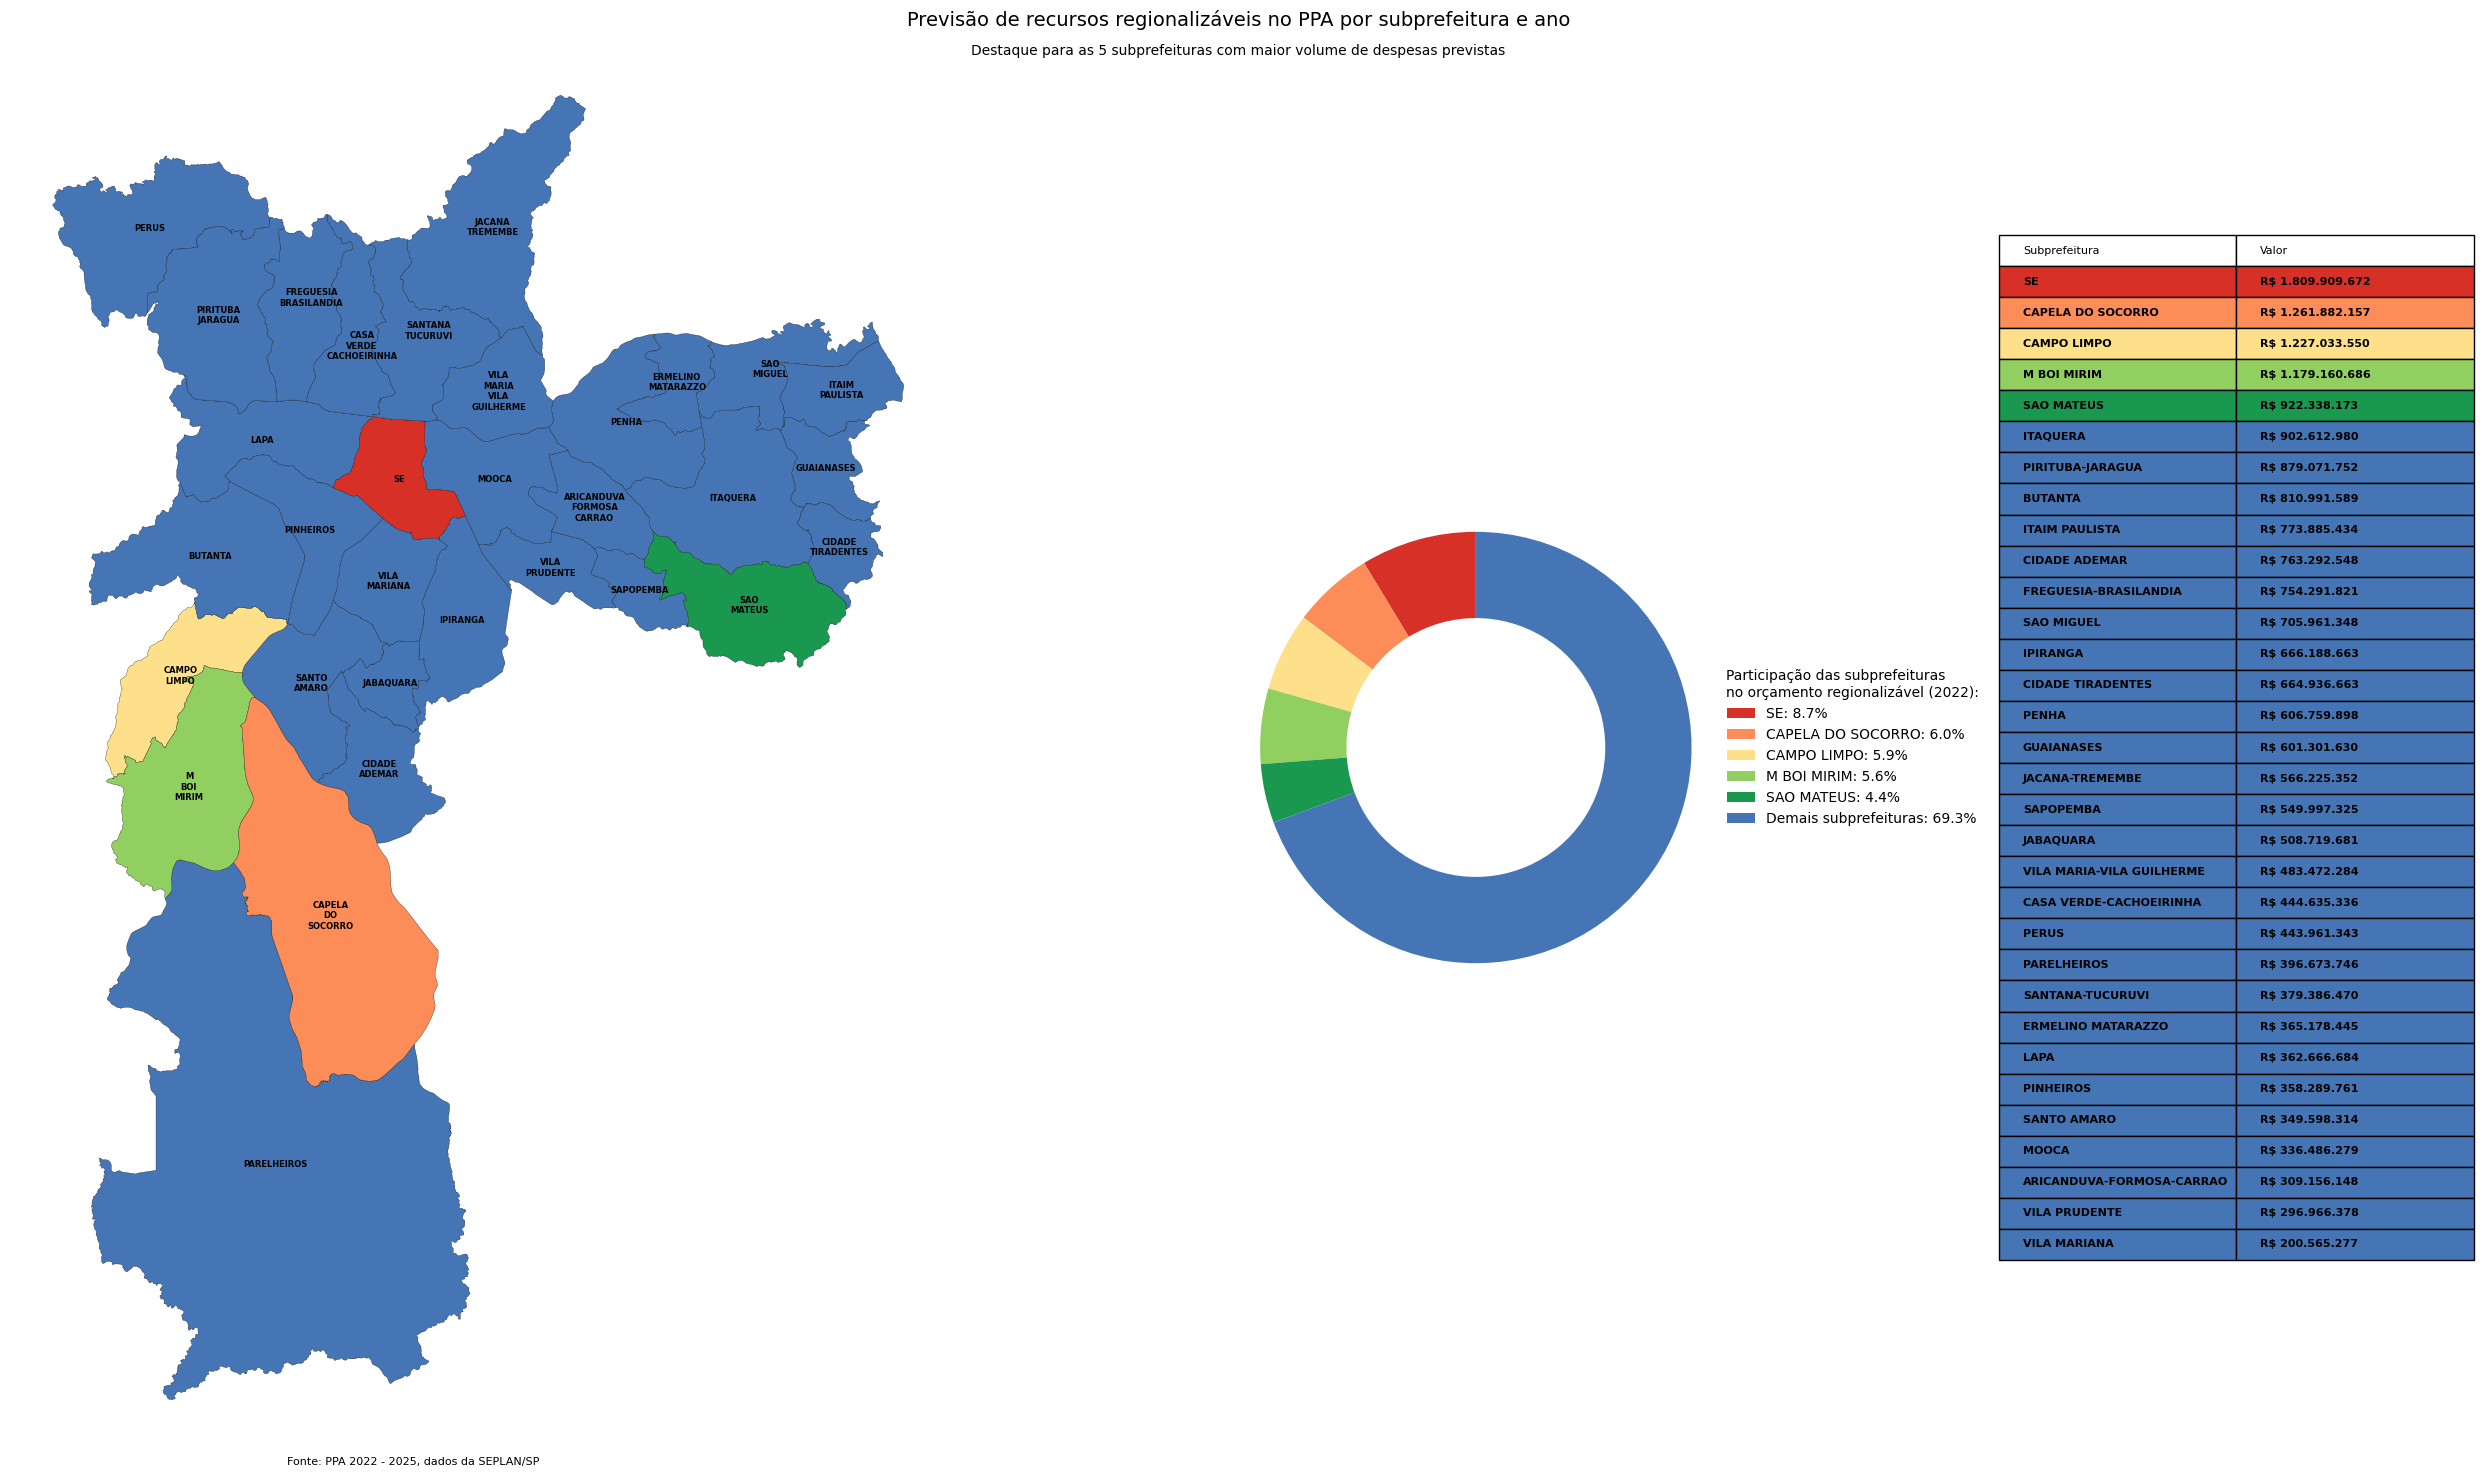

In [50]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

# --- Calcula centroides ---
gdf_mapa["centroid"] = gdf_mapa.geometry.centroid

# Dicionário de deslocamentos em metros (ajustes finos)
deslocamentos = {
    "FREGUESIA-BRASILANDIA": (500, 500),
    "CASA VERDE-CACHOEIRINHA": (500, -500),
    "SANTANA-TUCURUVI": (500, 500),
}

# Aplica deslocamentos criando colunas finais
gdf_mapa["desloc_x"] = gdf_mapa.apply(
    lambda row: row["centroid"].x + deslocamentos.get(row["nm_subpref"], (0,0))[0],
    axis=1
)

gdf_mapa["desloc_y"] = gdf_mapa.apply(
    lambda row: row["centroid"].y + deslocamentos.get(row["nm_subpref"], (0,0))[1],
    axis=1
)

# --- Calcula percentual do orçamento ---
gdf_mapa["percentual"] = gdf_mapa["valor 2022"] / gdf_mapa["valor 2022"].sum() * 100
gdf_mapa_sorted = gdf_mapa.sort_values("valor 2022", ascending=False)

# --- Top 5 + Outros ---
top5 = gdf_mapa_sorted.iloc[:5]
outros = pd.DataFrame({
    "nm_subpref": ["Demais subprefeituras"],
    "valor 2022": [gdf_mapa_sorted.iloc[5:]["valor 2022"].sum()],
    "percentual": [gdf_mapa_sorted.iloc[5:]["valor 2022"].sum() / gdf_mapa["valor 2022"].sum() * 100]
})

# Concatena Top5 + Outros
plot_df = pd.concat([top5[["nm_subpref", "valor 2022", "percentual"]], outros], ignore_index=True)

# --- Define cores específicas para cada posição ---
colors = ["#d73027", "#fc8d59", "#fee08b", "#91cf60", "#1a9850", "#4575b4"]  # top 5 + outros

# Cria dicionário de cores baseado no gráfico
color_map = dict(zip(plot_df["nm_subpref"], colors))

# Cria coluna de grupo no gdf (top5 ou Outros)
gdf_mapa["grupo_cor"] = gdf_mapa["nm_subpref"].where(gdf_mapa["nm_subpref"].isin(top5["nm_subpref"]), "Demais subprefeituras")

# Mapeia a cor para cada subprefeitura
gdf_mapa["cor"] = gdf_mapa["grupo_cor"].map(color_map)

# --- Cria figura com três subplots (mapa + rosca + tabela) ---
fig, (ax_map, ax_pie, ax_table) = plt.subplots(1, 3, figsize=(25, 15), gridspec_kw={'width_ratios': [2, 1, 1]})

# --- Mapa ---
gdf_mapa.plot(color=gdf_mapa["cor"],
              linewidth=0.2,
              edgecolor="black",
              ax=ax_map)

# Escreve nomes das subprefeituras
for _, row in gdf_mapa.iterrows():
    nome = "\n".join(row["nm_subpref"].replace("-", " ").split())
    ax_map.text(row["desloc_x"], row["desloc_y"],
                nome,
                fontsize=6,
                ha="center",
                va="center",
                fontweight="bold",
                color="black")

ax_map.axis("off")

# --- Gráfico de Rosca ---
wedges, texts = ax_pie.pie(
    plot_df["valor 2022"],
    labels=None,
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4)
)

# Legenda com nomes + percentual formatado
legend_labels = [f'{row["nm_subpref"]}: {row["percentual"]:.1f}%' for _, row in plot_df.iterrows()]
legend = ax_pie.legend(wedges, legend_labels,
                       title="Participação das subprefeituras\nno orçamento regionalizável (2022):",
                       loc="center left",
                       bbox_to_anchor=(1, 0.5),
                       fontsize=10)

legend.get_frame().set_linewidth(0)
legend.get_frame().set_facecolor("none")
ax_pie.axis("equal")

# --- Tabela de valores absolutos ---
# Ordena por valor decrescente e formata valores
gdf_mapa_sorted["valor_fmt"] = gdf_mapa_sorted["valor 2022"].apply(lambda x: f"R$ {x:,.0f}".replace(",", "."))

# Monta dados da tabela
table_data = []
for _, row in gdf_mapa_sorted.iterrows():
    table_data.append([row["nm_subpref"], row["valor_fmt"]])

# Converte em DataFrame para aplicar cores
table_df = pd.DataFrame(table_data, columns=["Subprefeitura", "Valor"])

# Cria tabela no subplot
ax_table.axis("off")
table = ax_table.table(cellText=table_df.values,
                       colLabels=table_df.columns,
                       cellLoc="left",
                       colLoc="left",
                       loc="center")

# Ajusta estilos da tabela
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)  # aumenta altura das linhas

# Aplica cores de fundo conforme grupo_cor
for i, subpref in enumerate(gdf_mapa_sorted["nm_subpref"]):
    cor = gdf_mapa_sorted.loc[gdf_mapa_sorted["nm_subpref"] == subpref, "cor"].values[0]
    for j in range(2):  # colunas Subprefeitura e Valor
        table[(i+1, j)].set_facecolor(cor)
        table[(i+1, j)].set_text_props(color="black", fontweight="bold")

# --- Título principal ---
fig.suptitle("Previsão de recursos regionalizáveis no PPA por subprefeitura e ano", fontsize=14)

# Título adicional logo abaixo do suptitle
fig.text(0.5, 0.95, "Destaque para as 5 subprefeituras com maior volume de despesas previstas", 
         ha='center', fontsize=10)

# --- Fonte ---
plt.figtext(0.17, 0.01, "Fonte: PPA 2022 - 2025, dados da SEPLAN/SP", ha="center", fontsize=8)

plt.tight_layout()
plt.show()
